<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/11/1119.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!apt install libcairo2-dev pkg-config python3-dev
!pip install igraph leidenalg cairocffi
!wget -O funcs.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/11/1119_funcs.py?raw=1
!wget -O 1119_zoo.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/1119_zoo.csv?raw=1
!wget -O 1119_class.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/1119_class.csv?raw=1

### Louvain clustering on categorical data

In [ ]:
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.neighbors import kneighbors_graph

import igraph as ig

from funcs import (
    print_clustering_stats,
    display_network_clusters_labels,
    plot_clust_stats
)

sns.set_theme()
plt.rcParams["figure.figsize"] = (10,10)
random.seed(2)

### Load and preprocess the zoo dataset

The Zoo Dataset is a comprehensive collection of data about various animals found in zoos worldwide. The dataset is composed of several attributes related to these animals, such as:

- `animal_name`: The name of the animal.

- `hair`: Indicates if the animal has hair (1 for yes, 0 for no).
- `feathers`: Indicates if the animal has feathers (1 for yes, 0 for no).
- `eggs`: Indicates if the animal lays eggs (1 for yes, 0 for no).
- `milk`: Indicates if the animal produces milk (1 for yes, 0 for no).
- `airborne`: Indicates if the animal can fly (1 for yes, 0 for no).
- `aquatic`: Indicates if the animal lives in water (1 for yes, 0 for no).
- `predator`: Indicates if the animal is a predator (1 for yes, 0 for no).
- `toothed`: Indicates if the animal has teeth (1 for yes, 0 for no).
- `backbone`: Indicates if the animal has a backbone (1 for yes, 0 for no).
- `breathes`: Indicates if the animal breathes air (1 for yes, 0 for no).
- `venomous`: Indicates if the animal is venomous (1 for yes, 0 for no).
- `fins`: Indicates if the animal has fins (1 for yes, 0 for no).
- `legs`: Number of legs the animal has (integer value).
- `tail`: Indicates if the animal has a tail (1 for yes, 0 for no).
- `domestic`: Indicates if the animal is domesticated (1 for yes, 0 for no).
- `catsize`: Indicates if the animal is cat-sized or larger (1 for yes, 0 for no).
- `class_type`: Numerical code indicating the animal's taxonomic class.


Citation : Forsyth,Richard. (1990). Zoo. UCI Machine Learning Repository. https://doi.org/10.24432/C5R59V.

In [ ]:
# Load the data
zoo_path = '1119_zoo.csv'
zoo_df = pd.read_csv(zoo_path)

# Load class mapping
class_mappings = '1119_class.csv'
class_mapper = pd.read_csv(class_mappings)

In [ ]:
zoo_df.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [ ]:
class_mapper

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


In [ ]:
zoo_df.shape

(101, 18)

In [ ]:
zoo_df.isna().sum(axis=0)

,0
animal_name,0
hair,0
feathers,0
eggs,0
milk,0
airborne,0
aquatic,0
predator,0
toothed,0
backbone,0


In [ ]:
# Check number of unique animals
zoo_df['animal_name'].nunique()

100

In [ ]:
# Drop duplicates since there should be one species per row
zoo_df = zoo_df.drop_duplicates('animal_name')
zoo_df.shape

(100, 18)

In [ ]:
# Map class id to class name
class_map_dict = class_mapper.set_index('Class_Number')['Class_Type'].to_dict()
zoo_df['class_type'] = zoo_df['class_type'].map(class_map_dict)

# Extract class as separate object and drop class from zoo_df
animal_class = zoo_df['class_type']
zoo_df = zoo_df.drop(columns=['class_type'])

In [ ]:
# Set animal name as index
zoo_df = zoo_df.set_index('animal_name', drop=True)

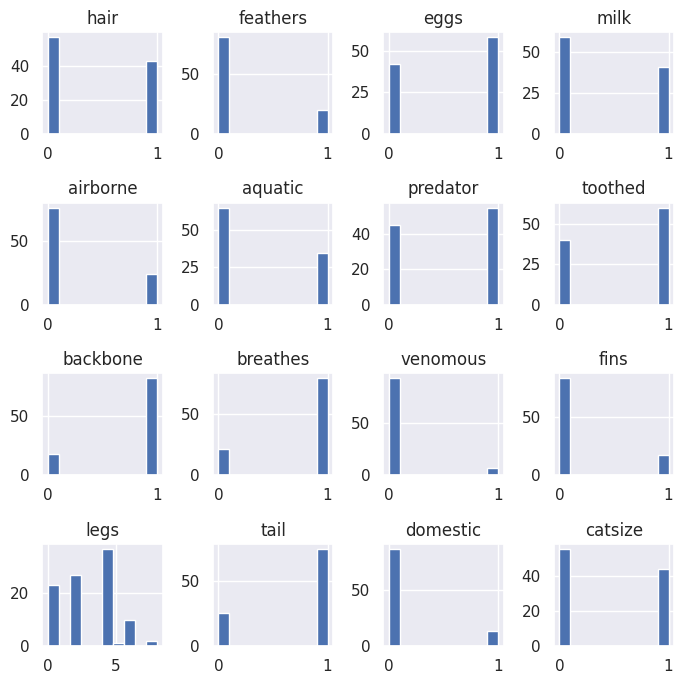

In [ ]:
_ = zoo_df.hist(figsize=(7,7))
plt.tight_layout()

### Encode and cluster the data

In [ ]:
N_NEIGHBORS = 10

In [ ]:
# Create KNN graph
distance_matrix = kneighbors_graph(zoo_df, n_neighbors=N_NEIGHBORS, mode='distance', metric='hamming')

# Eliminate zeros
distance_matrix.eliminate_zeros()

# Transform distance matrix into adjacency matrix
# we will use the natural way of transforming bounded distance measures into similarities
distance_matrix.data = 1.0 - distance_matrix.data
adj_matrix = distance_matrix

# Create graph from adjacency matrix
g = ig.Graph.Weighted_Adjacency(adj_matrix, mode="undirected")

In [ ]:
map_dict = {species_name:species_id for species_id, species_name in enumerate(set(animal_class))}
map_dict

{'Bird': 0,
 'Mammal': 1,
 'Bug': 2,
 'Reptile': 3,
 'Fish': 4,
 'Invertebrate': 5,
 'Amphibian': 6}

In [ ]:
# we will color the nodes based on animal class, and also we will plot our custom legend
# Colour the nodes
collor_palette = ig.ClusterColoringPalette(n=len(map_dict))
node_colors = [collor_palette[map_dict[species]] for species in animal_class]
g.vs['color'] = node_colors

legend_colors = []
legend_text = []
for species_name, species_id in map_dict.items():
    legend_colors.append(
        Line2D([0], [0], color=collor_palette[species_id], lw=4)
    )
    legend_text.append(str(species_name))

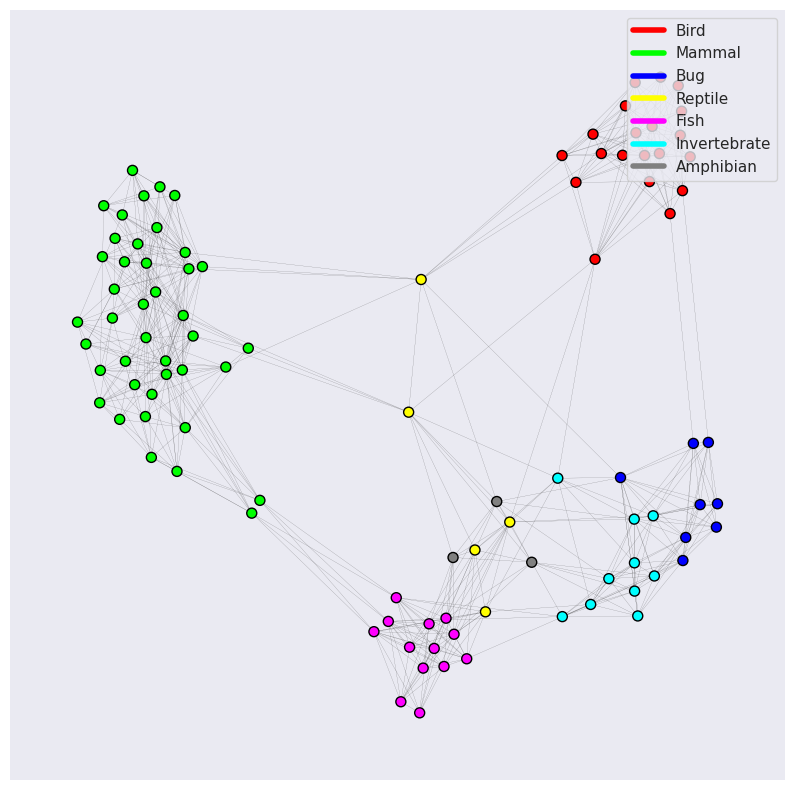

In [ ]:
# Use auto layout
lf_layout = g.layout_fruchterman_reingold(weights='weight')

_, ax = plt.subplots(figsize=(10,10))
ig.plot(
    g,
    vertex_size=10,
    edge_width=0.1,
    layout=lf_layout,
    target=ax
)

ax.legend(legend_colors, legend_text)

plt.show()
# this graph manages to represent the data to some extent
# so you can see that these groups are easy to identify
# but it seems that algorithm might have a hard time separating between these groups (top middle: Bug, Invertebrate)

In [ ]:
ig_clusters = ig.Graph.community_multilevel(
    g, resolution=1,
    weights='weight'
)

print_clustering_stats(
    ig_clusters=ig_clusters,
    min_cluster_size=0
)

Cluster 0 size : 41
Cluster 1 size : 20
Cluster 2 size : 21
Cluster 3 size : 18
Num regular clusters 4
Num noise clusters 0
Num noise cluster nodes 0


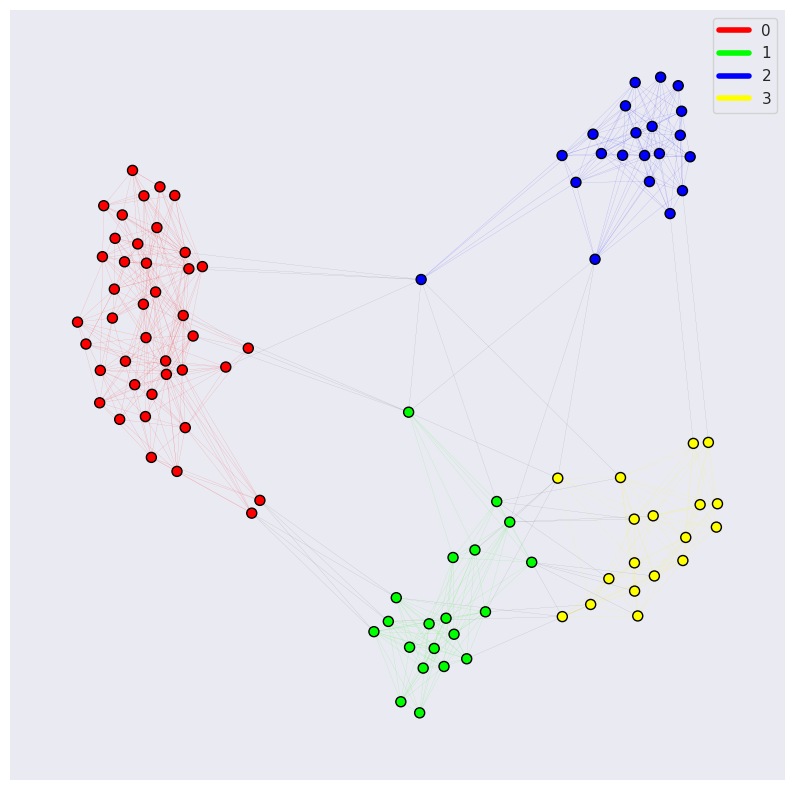

In [ ]:
display_network_clusters_labels(
    ig_clusters,
    vertex_size=10,
    edge_width=0.05,
    layout=lf_layout,
    color_edges=True,
    min_size=0
)
# the algorithm will manage to identify bigger groups but will also merge certain groups together (class 3)

In [ ]:
print('ARI : {}'.format(adjusted_rand_score(ig_clusters.membership, animal_class)))
# if we check the adjusted run score, it will be pretty high

ARI : 0.8908070315731951


Resolution 0.1
Resolution 0.2
Resolution 0.30000000000000004
Resolution 0.4
Resolution 0.5
Resolution 0.6
Resolution 0.7000000000000001
Resolution 0.8
Resolution 0.9
Resolution 1.0
Resolution 1.1
Resolution 1.2000000000000002
Resolution 1.3000000000000003
Resolution 1.4000000000000001


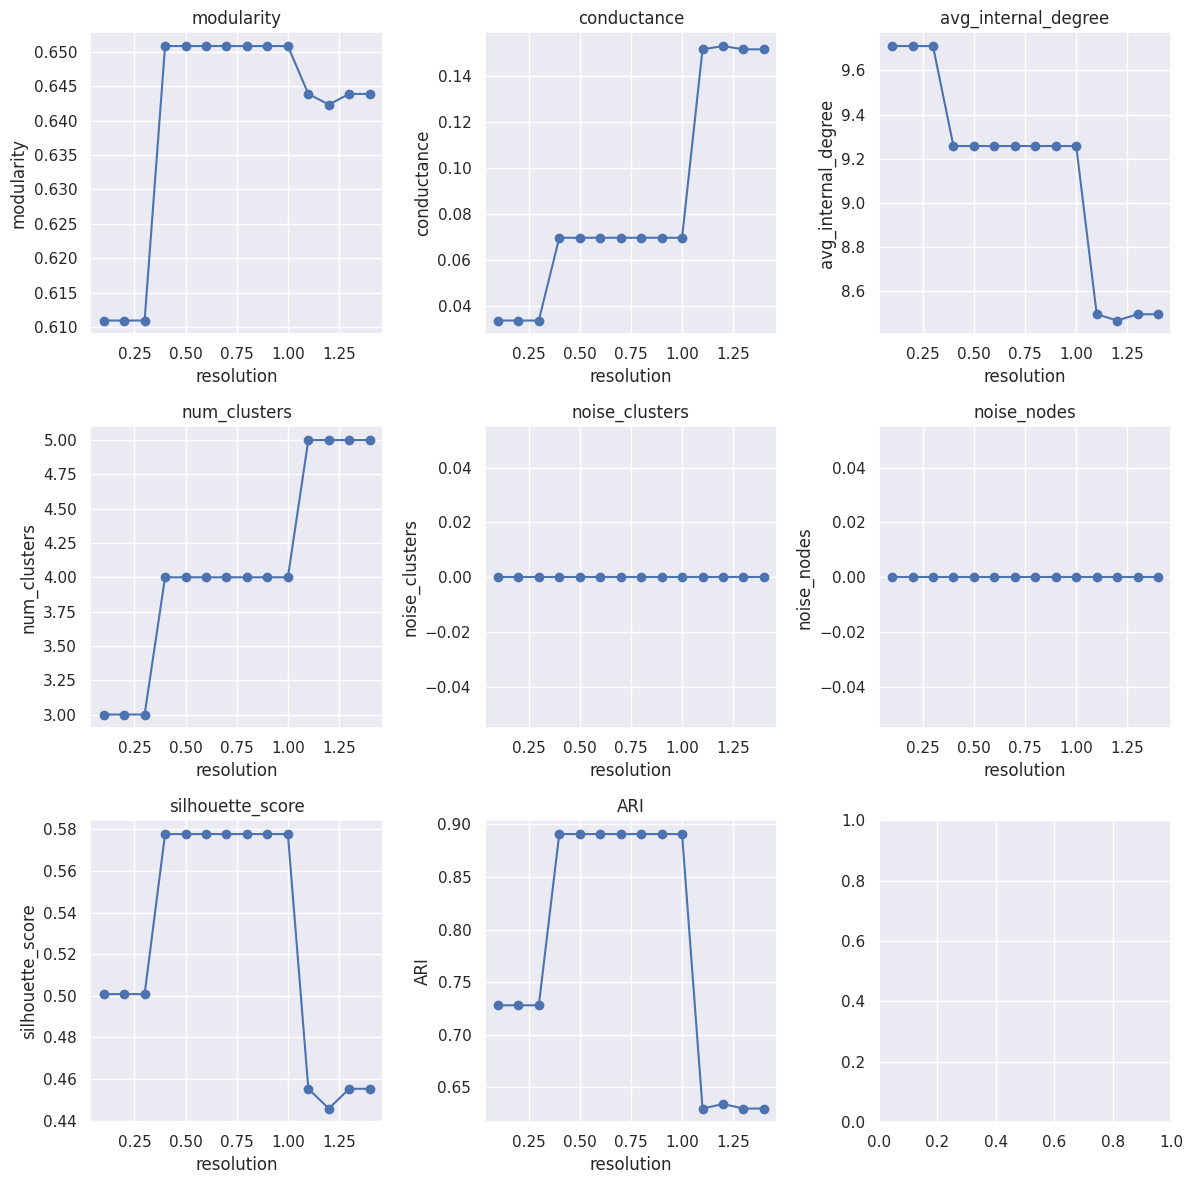

In [ ]:
plot_clust_stats(
    start_res=0.1,
    end_res=1.5,
    step=0.1,
    graph=g,
    original_data=zoo_df.to_numpy(),
    original_labels=animal_class,
    metric='hamming'
)
# that algorithm will frequently generate clustering having modularity of 0.65
# the conductance will grow and will actually change significantly between the start and end resolution
# average internal degree will remain more or less the same number of clusters will range between 3 and 5
# the silhouette score will be more or less the same
# in majority of situations we will wind up with adjusted rand score that is pretty high

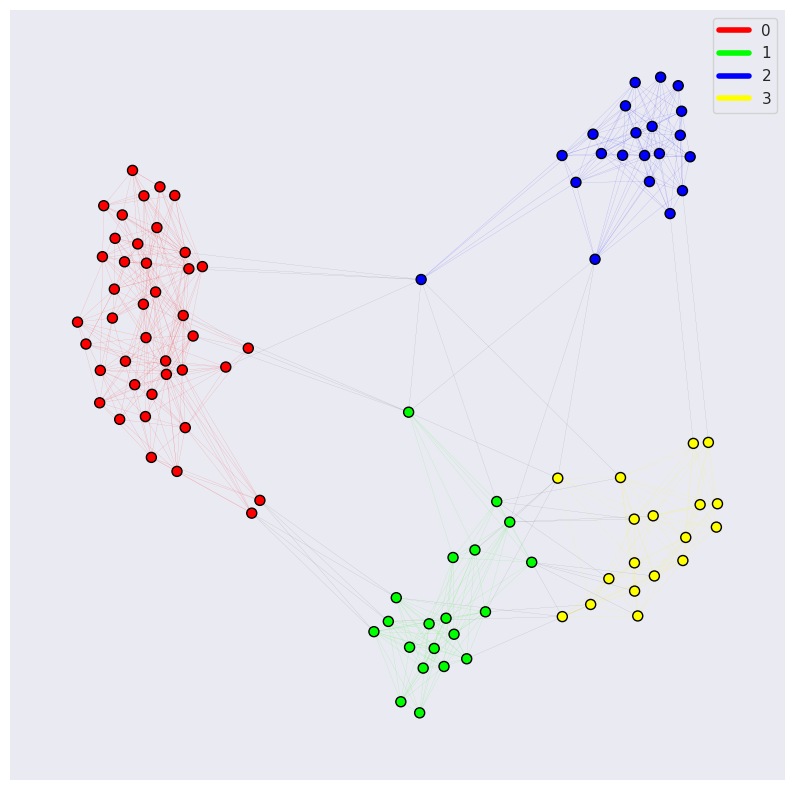

In [ ]:
ig_clusters = ig.Graph.community_multilevel(
    g, resolution=0.6, # resolution of 0.6 was ploted instead by mistake (影片說可以試試 1)
    weights='weight'
)

display_network_clusters_labels(
    ig_clusters,
    vertex_size=10,
    edge_width=0.05,
    layout=lf_layout,
    color_edges=True,
    min_size=0
)
# if we compare it with the original clustering, you can see that we have managed to capture this group,
# this group and this group, but we have merged these groups together
# so maybe by tweaking parameters, by choosing different graph types, we could perform better on this data set
# but we will wrap up here

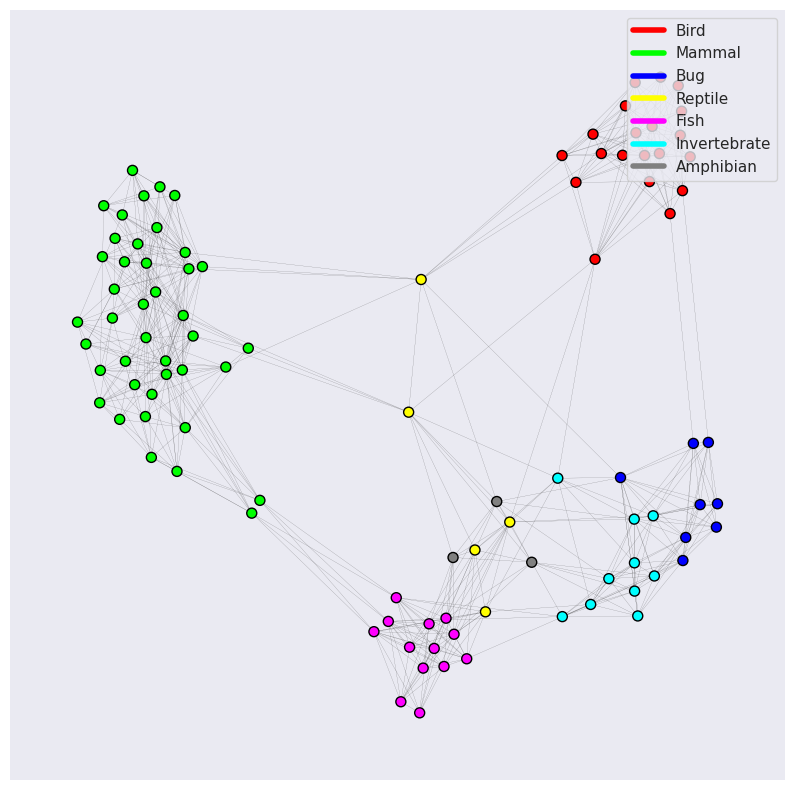

In [ ]:
_, ax = plt.subplots(figsize=(10,10))
ig.plot(
    g,
    vertex_size=10,
    edge_width=0.1,
    layout=lf_layout,
    target=ax
)

ax.legend(legend_colors, legend_text)

plt.show()